# Ease of Movement (EVM)

The Ease of Movement indicator involves several different calculations:

Distance Moved = ((High + Low) / 2 - (Prior High + Prior Low) / 2)

Box Ratio = (Volume / 100,000,000) / (High - Low)

1-Period EMV  = ((High + Low) / 2 - (Prior High + Prior Low) / 2) / ((Volume / 100,000,000 / (High - Low))

14-Period Ease of Movement = 14-period simple moving average of 1-period EMV

https://www.investopedia.com/terms/e/easeofmovement.asp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# fix_yahoo_finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'NESTLEIND.NS'
start = '2020-01-01'
end = '2023-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01 00:00:00+05:30,14819.000000,14849.349609,14712.250000,14779.049805,14130.988281,23859
2020-01-02 00:00:00+05:30,14848.900391,14852.950195,14687.150391,14729.349609,14083.467773,46116
2020-01-03 00:00:00+05:30,14750.000000,14795.000000,14556.099609,14593.599609,13953.671875,40000
2020-01-06 00:00:00+05:30,14542.000000,14542.000000,14275.000000,14416.650391,13784.480469,65136
2020-01-07 00:00:00+05:30,14423.549805,14546.750000,14260.849609,14290.750000,13664.100586,72237


In [3]:
# Create a function for Ease of Movement
def EVM(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EVM = dm / br 
    EVM_MA = pd.Series(EVM.rolling(ndays).mean(), name='EVM')
    data = data.join(EVM_MA) 
    return data

In [4]:
# Compute the 14-day Ease of Movement for stock
n = 14
Stock_EVM = EVM(df, n)
EVM = Stock_EVM['EVM']

[Text(18261.770833333332, 0, '2020-01'),
 Text(18382.770833333332, 0, '2020-05'),
 Text(18505.770833333332, 0, '2020-09'),
 Text(18627.770833333332, 0, '2021-01'),
 Text(18747.770833333332, 0, '2021-05'),
 Text(18870.770833333332, 0, '2021-09'),
 Text(18992.770833333332, 0, '2022-01'),
 Text(19112.770833333332, 0, '2022-05'),
 Text(19235.770833333332, 0, '2022-09'),
 Text(19357.770833333332, 0, '2023-01')]

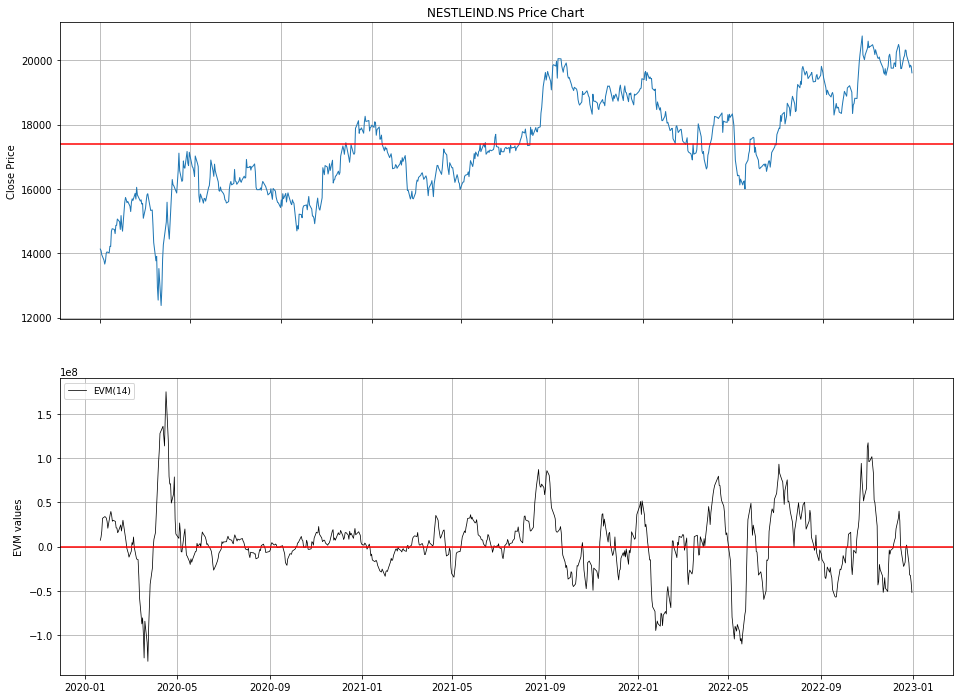

In [5]:
# Plotting the Price Series chart and the Ease Of Movement below
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2, 1, 1)
ax.set_xticklabels([])
ax.plot(df['Adj Close'],lw=1)
ax.axhline(y=df['Adj Close'].mean(),color='r')
ax.set_title(symbol + ' Price Chart')
ax.set_ylabel('Close Price')
ax.grid(True)

ax1 = fig.add_subplot(2, 1, 2)
ax1.plot(EVM,'k',lw=0.75,linestyle='-',label='EVM(14)')
ax1.axhline(y=0,color='r')
ax1.legend(loc=2,prop={'size':9})
ax1.set_ylabel('EVM values')
ax1.grid(True)
ax1 = plt.gca()
ax1.get_xticklabels()

## Candlestick with EVM

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc = dfc.dropna()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VolumePositive
0,18261.770833,14819.000000,14849.349609,14712.250000,14779.049805,14130.988281,23859,False
1,18262.770833,14848.900391,14852.950195,14687.150391,14729.349609,14083.467773,46116,False
2,18263.770833,14750.000000,14795.000000,14556.099609,14593.599609,13953.671875,40000,False
3,18266.770833,14542.000000,14542.000000,14275.000000,14416.650391,13784.480469,65136,False
4,18267.770833,14423.549805,14546.750000,14260.849609,14290.750000,13664.100586,72237,False


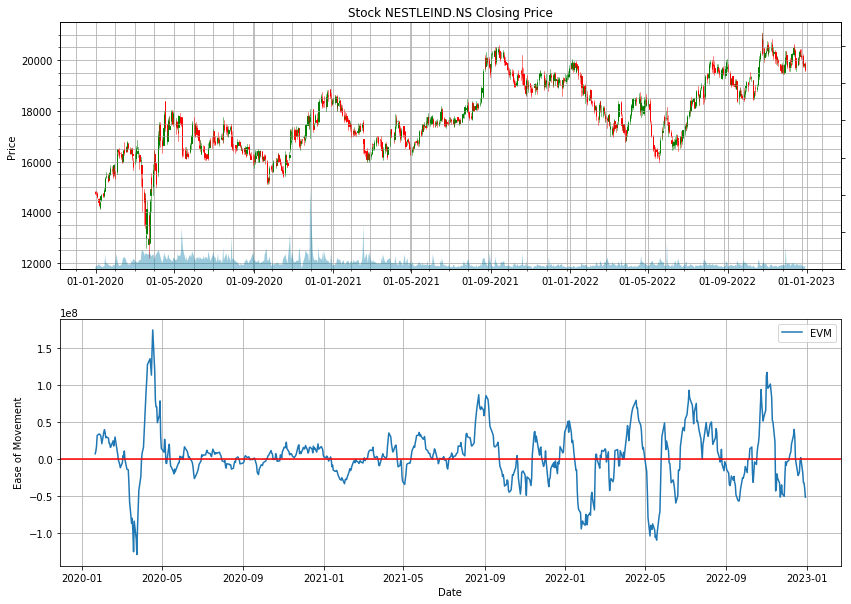

In [9]:
from mpl_finance import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
ax1v.fill_between(dfc.Date, 0, dfc.Volume[0:], facecolor='#0079a3', alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(EVM, label='EVM')
ax2.axhline(y=0,color='r')
ax2.grid()
ax2.set_ylabel('Ease of Movement')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

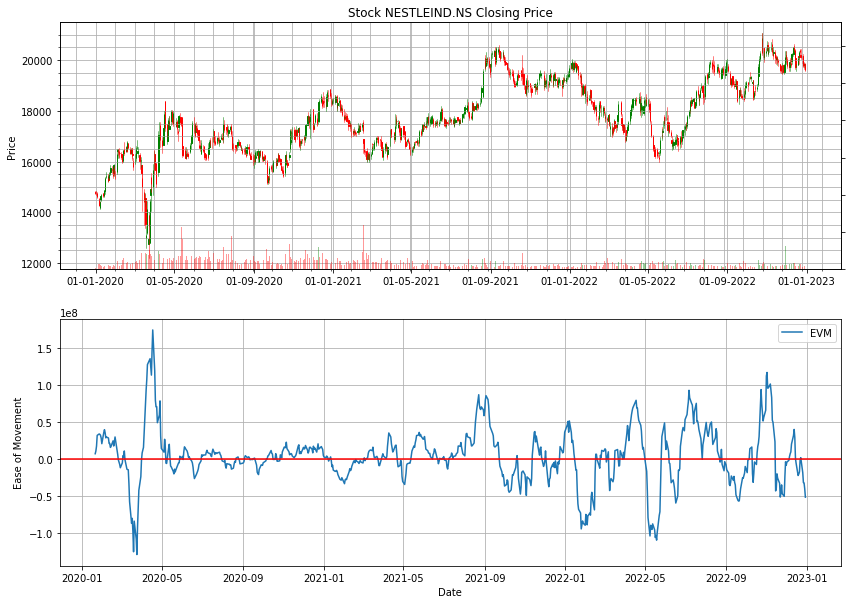

In [8]:
fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(EVM, label='EVM')
ax2.axhline(y=0,color='r')
ax2.grid()
ax2.set_ylabel('Ease of Movement')
ax2.set_xlabel('Date')
ax2.legend(loc='best')